In [1]:
import openmc
import numpy as np

### Constants

In [2]:
BISO_KERNEL_RADIUS   = 0.04 # cm  # r = 400 μm = 0.0400 cm // "800 μm kernel"
BISO_RADIUS          = 0.05 # cm  # r = 500 μm = 0.0500 cm // "100 μm thickness"
BISO_VOLUME          = (4 / 3) * np.pi * (BISO_RADIUS)**3            # volume of single BISO particle
KERNEL_VOLUME        = (4 / 3) * np.pi * (BISO_KERNEL_RADIUS)**3     # volume of UO2/ThO2 kernel in single BISO particle
BISO_KERNEL_VOL_FRAC = KERNEL_VOLUME / BISO_VOLUME  # vol frac kernel in single BISO
BISO_COAT_VOL_FRAC   = 1.0 - BISO_KERNEL_VOL_FRAC

### Materials

In [3]:
""" BISO particle """
# UO2 fuel kernel
uo2 = openmc.Material(name='UO2', temperature=900)
uo2.add_element('U', 1.0, enrichment=0.71)  
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.5)

# SiC coating
sic = openmc.Material(name='SiC', temperature=900)
sic.add_element('Si', 1.0)
sic.add_element('C', 1.0)
sic.set_density('g/cm3', 3.2)


""" Breeding material """
# Lead-lithium (Pb83at%-Li17at%)
pbli = openmc.Material(name='PbLi', temperature=900)
pbli.add_element('Pb', 0.83)
pbli.add_element('Li', 0.17, enrichment_target='Li6', enrichment_type='wo', enrichment=90.0)
pbli.set_density('g/cm3', 9.4) 

# FLiBe (LiF-BeF2) at 7.5 wt%-enriched Li-6
flibe07 = openmc.Material(name='FLiBe 7.5 wt% Li-6', temperature=900)
flibe07.add_elements_from_formula('F4Li2Be', 'ao', enrichment_target='Li6', enrichment_type='wo', enrichment=7.5)
flibe07.set_density('g/cm3', 1.94) 

# FLiBe (LiF-BeF2) at 20 wt%-enriched Li-6
flibe20 = openmc.Material(name='FLiBe 20 wt% Li-6', temperature=900)
flibe20.add_elements_from_formula('F4Li2Be', 'ao', enrichment_target='Li6', enrichment_type='wo', enrichment=20)
flibe20.set_density('g/cm3', 1.94) 

# Pebbles of Li2SiO4
li4sio4 = openmc.Material(name='Li2SiO4', temperature=900)
li4sio4.add_elements_from_formula('Li4SiO4', 'ao', enrichment_target='Li6', enrichment_type='wo', enrichment=60)
li4sio4.set_density('g/cm3', 2.42) 
be = openmc.Material(name='Be', temperature=900)
be.add_element('Be', 0.99, percent_type='wo')
be.add_element('O',  0.01, percent_type='wo')
be.set_density('g/cm3', 1.85) 
pebble = openmc.Material.mix_materials([li4sio4, be], [0.1304/(0.1304+0.3790), 0.3790/(0.1304+0.3790)], 'vo', temperature=900)
# pebble = openmc.Material(name='FLiBe 20 wt% Li-6', temperature=900)
# pebble.add_elements_from_formula('F4Li2Be', 'ao', enrichment_target='Li6', enrichment_type='wo', enrichment=20)
# pebble.set_density('g/cm3', 1.94) 


""" Homogeneous breeding mixtures """
biso = openmc.Material.mix_materials([uo2, sic], [BISO_KERNEL_VOL_FRAC, BISO_COAT_VOL_FRAC], 'vo', temperature=900)
flibe07_mix_01  = openmc.Material.mix_materials([flibe07, biso], [0.99, 0.01], 'vo', temperature=900)
flibe07_mix_50  = openmc.Material.mix_materials([flibe07, biso], [0.50, 0.50], 'vo', temperature=900)
flibe20_mix_01  = openmc.Material.mix_materials([flibe20, biso], [0.99, 0.01], 'vo', temperature=900)
flibe20_mix_50  = openmc.Material.mix_materials([flibe20, biso], [0.50, 0.50], 'vo', temperature=900)
pbli_mix_01     = openmc.Material.mix_materials([pbli, biso],    [0.99, 0.01], 'vo', temperature=900)
pbli_mix_50     = openmc.Material.mix_materials([pbli, biso],    [0.50, 0.50], 'vo', temperature=900)
pebble_mix_01   = openmc.Material.mix_materials([pebble, biso],  [0.99, 0.01], 'vo', temperature=900)
pebble_mix_50   = openmc.Material.mix_materials([pebble, biso],  [0.50, 0.50], 'vo', temperature=900)


""" Materials """
materials = openmc.Materials([uo2, sic, flibe07, flibe20, pbli, pebble, biso,
                              flibe07_mix_01, flibe07_mix_50, flibe20_mix_01, flibe20_mix_50, 
                              pbli_mix_01, pbli_mix_50, pebble_mix_01, pebble_mix_50])
materials.cross_sections = '/mnt/c/OpenMC/data/endfb-viii.0-hdf5/cross_sections.xml'
# materials.export_to_xml()

### Geometry

#### Helper functions

In [4]:
def cube_dims(biso_vol_frac):
    cube_length = ((4/3 * np.pi * BISO_RADIUS**3)/biso_vol_frac)**(1/3)
    cube_half   = cube_length / 2
    return cube_length, cube_half

def periodic_box(cube_half, offsets):

    xs = openmc.XPlane(x0= -cube_half + offsets[0], boundary_type = 'periodic')
    xg = openmc.XPlane(x0=  cube_half + offsets[0], boundary_type = 'periodic')

    ys = openmc.YPlane(y0= -cube_half + offsets[1], boundary_type = 'periodic')
    yg = openmc.YPlane(y0=  cube_half + offsets[1], boundary_type = 'periodic')

    zs = openmc.ZPlane(z0= -cube_half + offsets[2], boundary_type = 'periodic')
    zg = openmc.ZPlane(z0=  cube_half + offsets[2], boundary_type = 'periodic')

    xs.periodic_surface, ys.periodic_surface, zs.periodic_surface = xg, yg, zg

    region = +xs & -xg & +ys & -yg & +zs & -zg
    return region

def homogeneous(cid, biso_vol_frac, fill, offsets, label):
    _ , cube_half = cube_dims(biso_vol_frac)
    cell        = openmc.Cell(cell_id=cid, name=label)
    cell.fill   = fill
    cell.region = periodic_box(cube_half, offsets)
    return [cell]

def heterogeneous(cid, biso_vol_frac, breeder, offsets, label):
    uo2_outer = openmc.Sphere(x0=offsets[0], y0=offsets[1], z0=offsets[2], r=BISO_KERNEL_RADIUS)
    sic_outer = openmc.Sphere(x0=offsets[0], y0=offsets[1], z0=offsets[2], r=BISO_RADIUS)
    
    # UO2 kernel
    cell_uo2 = openmc.Cell(cell_id=int(cid), name=f'UO2 in cell: {label}')
    cell_uo2.fill = uo2
    cell_uo2.region = -uo2_outer
    
    # SiC coating
    cell_sic = openmc.Cell(cell_id=int(f'{cid}1'), name=f'SiC in cell: {label}')
    cell_sic.fill = sic
    cell_sic.region = +uo2_outer & -sic_outer
    
    # FLiBe
    _ , cube_half = cube_dims(biso_vol_frac)
    cell_breeder = openmc.Cell(cell_id=int(f'{cid}2'), name=f'Breeder in cell: {label}')
    cell_breeder.fill = breeder
    cell_breeder.region = +sic_outer & periodic_box(cube_half, offsets)
    return [cell_uo2, cell_sic, cell_breeder]

def logspace_per_decade(start, stop, pts_per_decade):
    """
    Returns values from 'start' to 'stop' so that each factor-of-10
    interval contains 'pts_per_decade' points (including its first endpoint).
    Might be a little off if 'stop' isn't precisely at a decade, ex. 20e6 eV

    example: 10 points per decade from 1e-5 → 2e7
    grid = logspace_per_decade(1e-5, 20e6, pts_per_decade=10)
    for i in grid:
        print(np.log10(i))
    # print(np.log10(i) for i in grid)
    """
    log_start = np.log10(start)
    log_stop  = np.log10(stop)
    total_decades = log_stop - log_start
    # how many intervals of size 1 decade we need, as a float
    total_steps = total_decades * pts_per_decade
    # +1 so that we include the very last point at 'stop'
    npts = int(np.ceil(total_steps)) + 1
    return np.logspace(log_start, log_stop, num=npts)

#### Generate cells
Boxes arranged in array where $i$-th entry is breeder material and $j$-th entry indicates BISO volume fraction and mixture.

In [5]:
""" Cells """
# BISO particle
uo2_outer = openmc.Sphere(r=BISO_KERNEL_RADIUS) # UO2 kernel sphere (radius = 0.04 cm)
sic_outer = openmc.Sphere(r=BISO_RADIUS)        # # SiC coating outer surface (radius = 0.04 + 0.01 = 0.05 cm)

# Cubes
x_coords = [0, 0.5, 1.0, 1.5]
y_coords = [0, -0.5, -1.0, -1.5]
coords = np.array([[(x, y, 0) for x in x_coords] for y in y_coords]) # 2 x 4 matrix of coordinates

labels = np.array([['FLiBe (7.5 wt% Li6) -  1 vol% BISO - homogeneous', 'FLiBe (7.5 wt% Li6) -  1 vol% BISO - heterogeneous', 'FLiBe (7.5 wt% Li6) - 50 vol% BISO - homogeneous', 'FLiBe (7.5 wt% Li6) - 50 vol% BISO - heterogeneous'],
                   ['FLiBe (20 wt% Li6) -  1 vol% BISO - homogeneous',  'FLiBe (20 wt% Li6) -  1 vol% BISO - heterogeneous',  'FLiBe (20 wt% Li6) - 50 vol% BISO - homogeneous',  'FLiBe (20 wt% Li6) - 50 vol% BISO - heterogeneous'],
                   ['LL -  1 vol% BISO - homogeneous' ,                 'LL -  1 vol% BISO - heterogeneous',                  'LL - 50 vol% BISO - homogeneous',                  'LL - 50 vol% BISO - heterogeneous'],
                   ['PB -  1 vol% BISO - homogeneous' ,                 'PB -  1 vol% BISO - heterogeneous',                  'PB - 50 vol% BISO - homogeneous',                  'PB - 50 vol% BISO - heterogeneous']])

cells = []
cells += homogeneous(  11, 0.01, flibe07_mix_01, coords[0,0], labels[0,0])
cells += heterogeneous(12, 0.01, flibe07,        coords[0,1], labels[0,1]) 
cells += homogeneous(  13, 0.50, flibe07_mix_50, coords[0,2], labels[0,2])
cells += heterogeneous(14, 0.50, flibe07,        coords[0,3], labels[0,3]) 
cells += homogeneous(  21, 0.01, flibe20_mix_01, coords[1,0], labels[1,0])
cells += heterogeneous(22, 0.01, flibe20,        coords[1,1], labels[1,1]) 
cells += homogeneous(  23, 0.50, flibe20_mix_50, coords[1,2], labels[1,2])
cells += heterogeneous(24, 0.50, flibe20,        coords[1,3], labels[1,3]) 
cells += homogeneous(  31, 0.01, pbli_mix_01,    coords[2,0], labels[2,0])
cells += heterogeneous(32, 0.01, pbli,           coords[2,1], labels[2,1]) 
cells += homogeneous(  33, 0.50, pbli_mix_50,    coords[2,2], labels[2,2])
cells += heterogeneous(34, 0.50, pbli,           coords[2,3], labels[2,3]) 
cells += homogeneous(  41, 0.01, pebble_mix_01,  coords[3,0], labels[3,0])
cells += heterogeneous(42, 0.01, pebble,         coords[3,1], labels[3,1]) 
cells += homogeneous(  43, 0.50, pebble_mix_50,  coords[3,2], labels[3,2])
cells += heterogeneous(44, 0.50, pebble,         coords[3,3], labels[3,3]) 

# Create universe and geometry
root_universe = openmc.Universe(cells=cells)
geometry = openmc.Geometry(root_universe)
# geometry.export_to_xml()

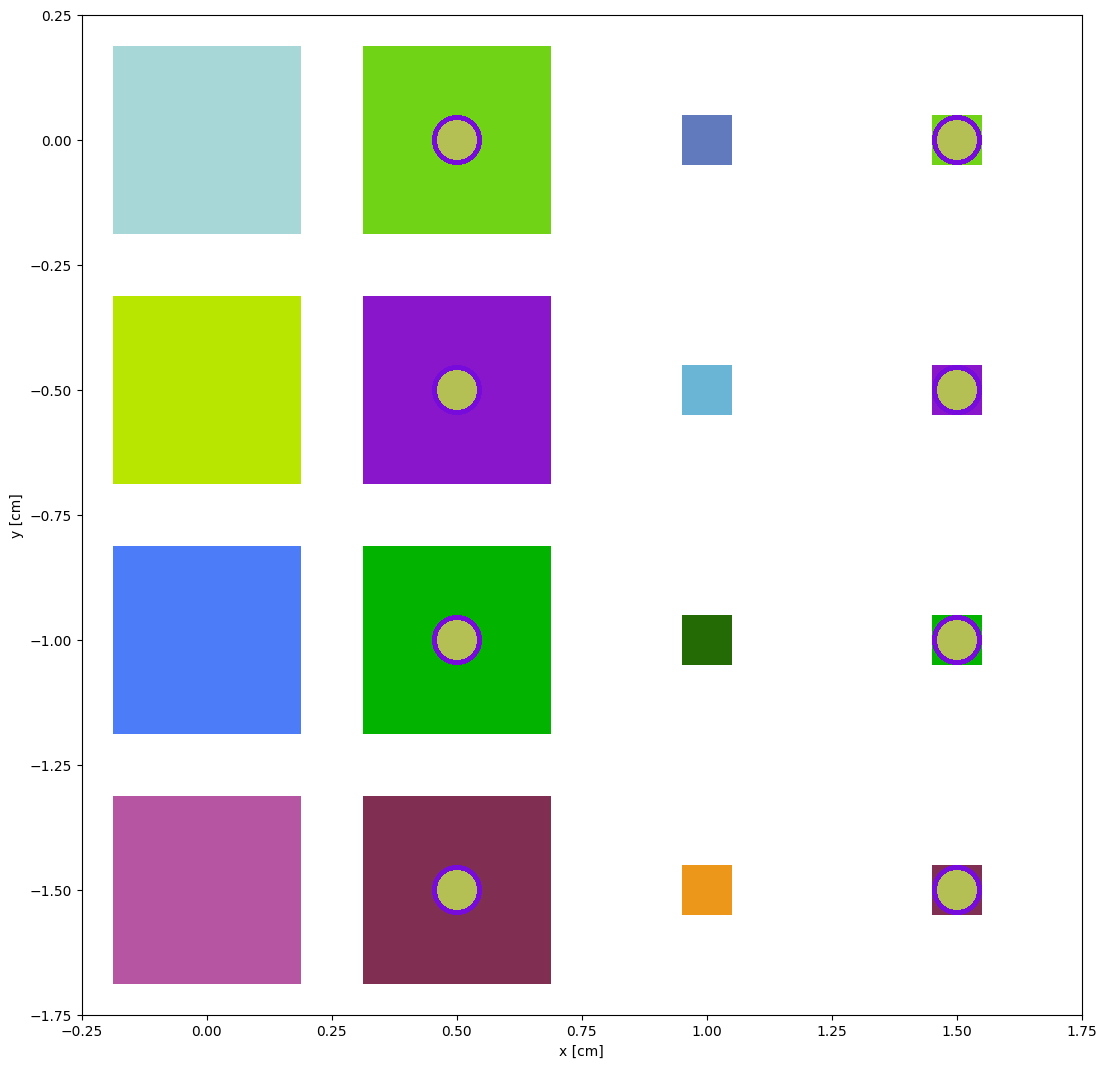

In [6]:
img = geometry.plot(origin=(0.75, -0.75, 0),
                    basis='xy',                           # slice plane
                    width=(2, 2),     # cm window
                    pixels=(1000, 1000),
                    color_by='material')

In [7]:
settings = openmc.Settings()

"""Source: 14 MeV"""
sources = []
cube_half_01, cube_half_50 = cube_dims(0.01)[-1], cube_dims(0.50)[-1]
bounds = np.array([[cube_half_01, cube_half_01, cube_half_50, cube_half_50],
                   [cube_half_01, cube_half_01, cube_half_50, cube_half_50],
                   [cube_half_01, cube_half_01, cube_half_50, cube_half_50],
                   [cube_half_01, cube_half_01, cube_half_50, cube_half_50]])

for i, j in np.ndindex(bounds.shape):  
    ch = bounds[i, j]
    x, y, z = coords[i, j]
    source = openmc.IndependentSource()
    source.space = openmc.stats.Box([x-ch, y-ch, z-ch], [x+ch, y+ch, z-ch+1e-5])
    source.particle = 'neutron'
    source.constraints = {'fissionable': False}
    source.energy = openmc.stats.Discrete([14.0e6], [1.0])  # 14 MeV
    source.angle  = openmc.stats.Monodirectional((0, 0, 1))
    # source.angle = openmc.stats.Isotropic()
    sources.append(source)

"""Settings"""
settings.run_mode  = "fixed source"
settings.batches   = 10
settings.particles = int(16e4)
settings.source    = sources
settings.volume_normalized_flux_tallies = True
settings.temperature = {'default':900}
# settings.write_initial_source = True
# settings.sourcepoint = {'batches':[10],'write':True}

In [8]:
"""Tallies"""
tallies = openmc.Tallies()
cell_filter = openmc.CellFilter(cells)
energy_filter = openmc.EnergyFilter(logspace_per_decade(1e-5, 20e6, 100))

# 2d mesh tally
for i, j in np.ndindex(bounds.shape):  
    c = int(10*(i+1) + (j+1))
    if c in [12,14,22,24,32,34]:
        ch = cube_half_01 # bounds[i, j]
        x, y, z = coords[i, j]
        
        mesh2d = openmc.RegularMesh()
        mesh2d.dimension = [100, 100, 1]                  
        mesh2d.lower_left  = [x-ch, y-ch, z-0.005]  
        mesh2d.upper_right = [x+ch, y+ch, z+0.005]
        mesh2d_filter = openmc.MeshFilter(mesh2d)
        
        t_mesh2d = openmc.Tally(name=f'flux {c}')
        t_mesh2d.filters = [mesh2d_filter]
        t_mesh2d.scores = ['flux', 'fission', 'absorption', '(n,gamma)', '(n,Xt)', '(n,2n)']
        tallies.append(t_mesh2d)
    
        t_mesh2d_eb = openmc.Tally(name=f'flux spectrum {c}')
        t_mesh2d_eb.filters = [mesh2d_filter, energy_filter]
        t_mesh2d_eb.scores = ['flux', 'fission', 'absorption', '(n,gamma)', '(n,Xt)', '(n,2n)']
        tallies.append(t_mesh2d_eb)

# total rxn rates
t_tot = openmc.Tally(name="total rxn rates")
t_tot.scores = ["absorption", "fission", "(n,gamma)", "(n,2n)", "(n,Xt)"]
t_tot.filters = [cell_filter]
tallies.append(t_tot)

# rxn rates by isotope
t_iso = openmc.Tally(name="rxn rates by isotope")
t_iso.scores = ["absorption", "fission", "(n,gamma)", "(n,2n)", "(n,Xt)"]
t_iso.filters = [cell_filter]
t_iso.nuclides = ['U238', 'U235']
tallies.append(t_iso)

# rxn rates by isotope by energy bins
t_iso_eb = openmc.Tally(name="rxn rate spectrum by isotope")
t_iso_eb.scores = ["absorption", "fission", "(n,gamma)", "(n,2n)", "(n,Xt)"]
t_iso_eb.filters = [cell_filter, energy_filter]
t_iso_eb.nuclides = ['U238', 'U235']
tallies.append(t_iso_eb)

In [9]:
model = openmc.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./BISO_combined")
model.run(cwd="./BISO_combined") 

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/mnt/c/MCNP/emma-openmc/Jupyter/BISO_combined/statepoint.10.h5')

In [14]:
cells = (11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44) # needs to be tuples for some reason

sp = openmc.StatePoint("./BISO_combined/statepoint.10.h5" )

u238_rr = sp.get_tally(name='rxn rates by isotope')
absorption = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[cells], nuclides=['U238'], scores=['absorption'])
fission    = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[cells], nuclides=['U238'], scores=['fission'])
n_gamma    = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[cells], nuclides=['U238'], scores=['(n,gamma)'])
n_2n       = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[cells], nuclides=['U238'], scores=['(n,2n)'])

flibe07_01_heter = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(11,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
flibe07_01_homog = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(12,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
flibe07_50_heter = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(13,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
flibe07_50_homog = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(14,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
flibe20_01_heter = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(21,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
flibe20_01_homog = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(22,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
flibe20_50_heter = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(23,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
flibe20_50_homog = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(24,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
ll_01_heter      = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(31,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
ll_01_homog      = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(32,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
ll_50_heter      = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(33,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
ll_50_homog      = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(34,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
pb_01_heter      = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(41,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
pb_01_homog      = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(42,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
pb_50_heter      = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(43,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])
pb_50_homog      = u238_rr.get_slice(filters=[openmc.CellFilter], filter_bins=[(44,)], nuclides=['U238'], scores=['absorption','fission', '(n,gamma)', '(n,2n)'])

print(fission.get_pandas_dataframe())
print(n_gamma.get_pandas_dataframe())
# print(flibe07_01_homog.get_pandas_dataframe())
# print(flibe07_01_heter.get_pandas_dataframe())
# print(flibe07_01_homog.get_pandas_dataframe())
# print(flibe07_50_heter.get_pandas_dataframe())
# print(flibe07_50_homog.get_pandas_dataframe())
# print(flibe20_01_homog.get_pandas_dataframe())
# print(flibe20_01_heter.get_pandas_dataframe())
# print(flibe20_01_homog.get_pandas_dataframe())
# print(flibe20_50_heter.get_pandas_dataframe())
# print(flibe20_50_homog.get_pandas_dataframe())
# print(ll_01_heter.get_pandas_dataframe())
# print(ll_01_homog.get_pandas_dataframe())
# print(ll_50_heter.get_pandas_dataframe())
# print(ll_50_homog.get_pandas_dataframe())
# print(pb_01_heter.get_pandas_dataframe())
# print(pb_01_homog.get_pandas_dataframe())
# print(pb_50_heter.get_pandas_dataframe())
# print(pb_50_homog.get_pandas_dataframe())


    cell nuclide    score     mean  std. dev.
0     11    U238  fission 4.25e-03   2.65e-05
1     12    U238  fission 4.14e-03   3.66e-05
2     13    U238  fission 1.77e-01   6.20e-04
3     14    U238  fission 1.73e-01   8.34e-04
4     21    U238  fission 4.18e-03   9.32e-06
5     22    U238  fission 4.07e-03   3.22e-05
6     23    U238  fission 1.75e-01   6.87e-04
7     24    U238  fission 1.71e-01   8.74e-04
8     31    U238  fission 5.16e-03   2.17e-05
9     32    U238  fission 5.16e-03   2.21e-05
10    33    U238  fission 1.84e-01   5.69e-04
11    34    U238  fission 1.79e-01   7.41e-04
12    41    U238  fission 3.51e-03   1.31e-05
13    42    U238  fission 3.48e-03   1.80e-05
14    43    U238  fission 1.62e-01   6.89e-04
15    44    U238  fission 1.62e-01   8.22e-04
    cell nuclide      score     mean  std. dev.
0     11    U238  (n,gamma) 4.00e-02   3.84e-04
1     12    U238  (n,gamma) 3.04e-02   2.58e-04
2     13    U238  (n,gamma) 9.47e-01   5.07e-03
3     14    U238  (n,gamma

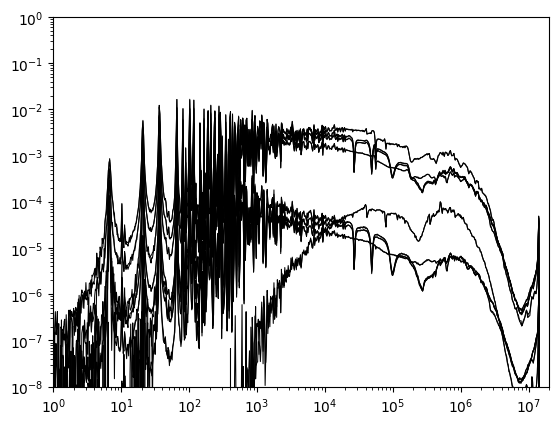

In [38]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Fonts
try:
    font_path = './Python/fonts/DIN-Regular.ttf' # DIN-Regular.ttf' # './Python/arial.ttf'
    fm.fontManager.addfont(font_path)
    prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
except:
    font_path = './Python/fonts/arial.ttf' # './arial.ttf'
    fm.fontManager.addfont(font_path)
    prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()

# Ticks
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 0.5   # major x‐tick line width
plt.rcParams['ytick.major.width'] = 0.5   # major y‐tick line width
plt.rcParams['xtick.major.size'] = 6      # major x‐tick line length
plt.rcParams['ytick.major.size'] = 6      # major y‐tick line length
plt.rcParams['xtick.minor.size'] = 3      # minor x‐tick line length
plt.rcParams['ytick.minor.size'] = 3      # minor y‐tick line length
plt.rcParams['axes.linewidth']    = 0.5   # axes spines linewidth (use this instead of messing with spine.set_linewidth(1) )

# Font sizes
plt.rcParams['font.size']          = 14   # default text size for labels, legends, etc.
plt.rcParams['axes.titlesize']     = 14   # axes title
plt.rcParams['axes.labelsize']     = 14   # x- and y-axis labels
plt.rcParams['xtick.labelsize']    = 14   # x-tick labels
plt.rcParams['ytick.labelsize']    = 14   # y-tick labels
plt.rcParams['legend.fontsize']    = 12   # legend text
plt.rcParams['figure.titlesize']   = 14   # figure title


In [ ]:
plt.figure()
plt.xscale('log'), plt.yscale('log')
plt.xlim(1e0,2e7), plt.ylim(1e-8,1e0)

n_gamma_eb = sp.get_tally(name='rxn rate spectrum by isotope') 

for c in [11,12,13,14,21,22,23,24,31,32,33,34,41,42,43,44]:
    tt = n_gamma_eb.get_slice(nuclides=['U238'], scores=['(n,gamma)'], filters=[openmc.CellFilter], filter_bins=[(c,)])
    df = tt.get_pandas_dataframe()
    df['energy mid [eV]'] = (df['energy low [eV]'] + df['energy high [eV]'])/ 2
    plt.plot(df['energy mid [eV]'], df['mean'], markersize=2, linewidth=0.75, color='#000000', label=f'OpenMC')